<h1>A2 - Banco de dados</h1>
<div>Cleomar Felipe Rabelo Antoszczyszyn<br>
    Gabriel Pastori Figueira</div>

<h2>1 Introdução</h2>
<p>Esse notebook apresenta análises referentes à qualidade da água coletada diferentes pontos de monitoramento do Brasil, em 2017. Para isso, foram usados dados disponibilizados pelo Governo do Brasil, os quais podem ser acessados através do seguinte endereço: <a href="https://dados.gov.br/dataset/indice-de-qualidade-da-agua-media-de-2017">https://dados.gov.br/dataset/indice-de-qualidade-da-agua-media-de-2017</a></p>

<h2>2 Desenvolvimento</h2>
<h3>2.1 Bibliotecas</h3>
<p>A célula de código abaixo possui a importação das bibliotecas usadas no projeto e deve ser executada para tudo funcionar corretamente. Além disso, antes de executar a célula abaixo, é necessário instalar as bibliotecas do arquivo requirements.txt no seu ambiente atual.</p>

In [112]:
import pandas as pd
import geopandas as gpd
import geoplot.crs as gcrs
from shapely import wkt
import getpass
import pymysql
import matplotlib
import geoplot as gplt

<h3>2.2 Conexão com o MySQL</h3>
<p>Ao escolher o banco de dados, optamos pelo tipo relacional e pelo sistema MySQL. Primeiramente, deve-se executar o arquivo schema.sql no MySQL e os arquivos citiesgeo_to_mysql.py e points_to_mysql.py em algum interpretador Python. Feito isso, a célula abaixo deve ser executada para a conexão com o banco de dados ser efetuada.</p>

In [111]:
password = getpass.getpass()

database = 'geodata'
user = 'root'
host='localhost'

con = pymysql.connect(host=host, user=user, passwd=password, database=database)
cur = con.cursor()
con.autocommit(True)

 ········


<h3>2.3 Qualidade da água no mapa do Brasil</h3>
<p>Para serem feitas as visualizações, os dados devem estar dispostos em um formato de dataframe. Primeiramente, obtemos os pontos de coleta de água do banco de dados, que estão na tabela point.</p>

In [113]:
points = pd.read_sql("select code, responsible, water_body, year, count, mean, min, max, stddev, variance, ST_AsText(geometry) as geometry, state_initial from point", con)

points['geometry'] = points['geometry'].apply(wkt.loads)
points_gpd = gpd.GeoDataFrame(points, geometry="geometry")

points.head()

,code,responsible,water_body,year,count,mean,min,max,stddev,variance,geometry,state_initial
0,00MS23CH2018,IMASUL,Rio Cachoeirão,2017,6,73.666667,70.6,75.3,2.377113,5.650667,POINT (-55.27222 -20.47750),MS
1,00MS23CN2002,IMASUL,Rio Canastrão,2017,6,70.166667,65.9,72.7,3.324254,11.050667,POINT (-55.11056 -20.64083),MS
2,00MS23MI0602,IMASUL,Rio Miranda,2017,6,71.633333,70.7,73.0,1.081974,1.170667,POINT (-56.12030 -21.48310),MS
3,00MS23MI1292,IMASUL,Rio Miranda,2017,6,63.166667,60.1,67.2,3.262310,10.642667,POINT (-56.39917 -20.24083),MS
4,00MS23MI2000,IMASUL,Rio Miranda,2017,6,70.000000,61.6,75.2,6.567800,43.136000,POINT (-57.33806 -19.42139),MS


<p>Em seguida, obtemos os contornos das cidades do Brasil, os quais são encontrados na tabela city.</p>

In [114]:
cities = pd.read_sql("select name,ST_AsText(geometry) as geometry,fk_city_state as state from city", con)

cities['geometry'] = cities['geometry'].apply(wkt.loads)
cities_gpd = gpd.GeoDataFrame(cities, geometry="geometry")
extent = (cities_gpd.total_bounds)

cities.head()

,name,geometry,state
0,Acrelândia,"POLYGON ((-67.13305 -9.67614, -67.05956 -9.708...",AC
1,Assis Brasil,"POLYGON ((-69.58777 -10.37119, -69.58226 -10.3...",AC
2,Brasiléia,"POLYGON ((-69.12877 -10.40171, -69.13691 -10.4...",AC
3,Bujari,"POLYGON ((-68.21979 -9.24215, -67.97663 -9.352...",AC
4,Capixaba,"POLYGON ((-67.77317 -10.24188, -67.77008 -10.2...",AC


<p>Feito isso, podemos finalmente criar o gráfico do Brasil e os pontos de coleta de água. Quanto mais intenso for a cor azul de um ponto específico, melhor a qualidade da água naquele ponto de coleta.</p>

<GeoAxesSubplot:>

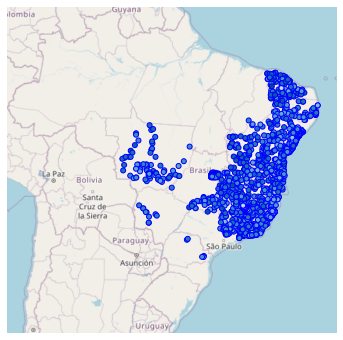

In [116]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
cmap = matplotlib.pyplot.cm.get_cmap('Blues')

br_ax = gplt.webmap(cities_gpd, projection = gcrs.WebMercator())
gplt.pointplot(points_gpd, ax=br_ax, hue=points_gpd['mean'], edgecolor="blue", norm=norm, cmap=cmap, extent=extent)

<h3>2.4 Ranking dos estados</h3>

A seguir, é mostrado o ranking dos estados em relação à qualidade média da água.

In [117]:
grouped_points = points_gpd.groupby(['state_initial']).mean()
grouped_points = grouped_points.sort_values(by=['mean'], ascending = False)[['mean']].rename(columns={'mean': 'Média'})
grouped_points.index.name = 'UF'
grouped_points

,Média
UF,
CE,71.993940
DF,70.763968
RN,70.438095
MS,68.723333
MT,67.799156
BA,65.749661
PE,65.622817
PR,64.210000
MG,64.055414


O estado que possui a melhor qualidade média é o Ceará, com 71.99, enquanto o Rio de Janeiro possui a pior, com 48.33 de qualidade média de seus corpos hídricos.

<h3>2.5 Distribuição dos corpos hídricos do Rio de Janeiro e do Ceará</h3>

Primeiramente, vamos observar a distribuição dos corpos hídricos (pontos de coleta) no estado com pior qualidade média de água, o Rio de janeiro. Lembrando que, quanto mais intenso for o tom de azul em um ponto, de maior qualidade é a água daquele ponto.

<GeoAxesSubplot:>

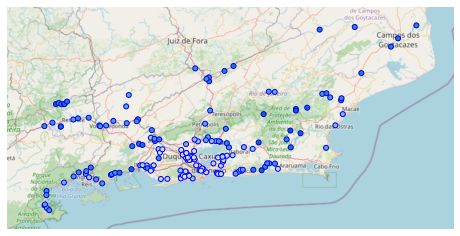

In [118]:
rj_points = points_gpd[points_gpd['state_initial']=='RJ']
rj_map = cities_gpd[cities_gpd['state']=='RJ']

rj_ax = gplt.webmap(rj_map, projection = gcrs.WebMercator())
gplt.pointplot(rj_points, ax=rj_ax, hue=points_gpd['mean'], norm=norm, cmap=cmap, edgecolor="blue")

Vamos observar agora os corpos hídricos do estado com melhor qualidade média de água, o Ceará.

<GeoAxesSubplot:>

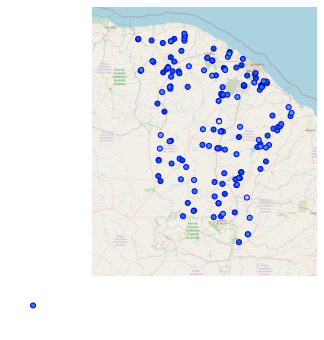

In [119]:
ce_points = points_gpd[points_gpd['state_initial']=='CE']
ce_map = cities_gpd[cities_gpd['state']=='CE']

ce_ax = gplt.webmap(ce_map, projection = gcrs.WebMercator())
gplt.pointplot(ce_points, ax=ce_ax, hue=points_gpd['mean'], norm=norm, cmap=cmap, edgecolor="blue")

<h3>2.6 Distribuição dos corpos hídricos em brasília</h3>

Vamos observar também como está distribuída a qualidade da água em Brasília, capital do Brasil, que ficou em segundo lugar no ranking dos estados.

<GeoAxesSubplot:>

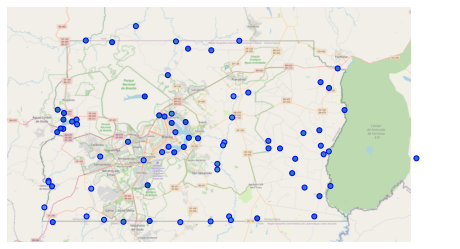

In [120]:
df_map = cities_gpd[cities_gpd['state'] == 'DF']
df_points = points_gpd[points_gpd['state_initial'] == 'DF']

df_ax = gplt.webmap(df_map, projection = gcrs.WebMercator())
gplt.pointplot(df_points, ax=df_ax, hue=points_gpd['mean'], norm=norm, cmap=cmap, edgecolor="blue")

# Análise dos corpos hidrográficos do Paraná

In [19]:
pr_map = cities_gpd[cities_gpd['state'] == 'PR']
pr_points = points_gpd[points_gpd['state_initial'] == 'PR']
pr_points

,code,responsible,water_body,year,count,mean,min,max,stddev,variance,geometry,state_initial
333,64504450,Águas Paraná,Rio Apertados,2017,2,72.30,72.3,72.3,0.000000,0.000000,POINT (-51.30944 -23.46528),PR
334,64504591,Águas Paraná,Ribeirão Cafezal,2017,2,71.90,71.9,71.9,0.000000,0.000000,POINT (-51.19611 -23.35444),PR
335,65006040,Águas Paraná,Rio Palmital,2017,2,69.70,69.7,69.7,0.000000,0.000000,POINT (-49.16222 -25.32200),PR
336,65007046,Águas Paraná,Rio Atuba,2017,2,45.90,45.9,45.9,0.000000,0.000000,POINT (-49.19791 -25.44682),PR
337,65021800,Águas Paraná,Rio Passaúna,2017,4,61.25,53.4,69.1,9.064399,82.163333,POINT (-49.38778 -25.42630),PR


In [20]:
points_pr = pr_points['geometry']
point_pr_cities = []


for point in points_pr:
    for index, city in cities_gpd.iterrows():
        cityG = city['geometry']
        cityN = city['name']
        if(cityG.contains(point)):
            point_pr_cities.append(cityN)
            break

pr_points['city'] = point_pr_cities
pr_points

C:\Users\cleom\anaconda3\envs\a2bd\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,code,responsible,water_body,year,count,mean,min,max,stddev,variance,geometry,state_initial,city
333,64504450,Águas Paraná,Rio Apertados,2017,2,72.30,72.3,72.3,0.000000,0.000000,POINT (-51.30944 -23.46528),PR,Londrina
334,64504591,Águas Paraná,Ribeirão Cafezal,2017,2,71.90,71.9,71.9,0.000000,0.000000,POINT (-51.19611 -23.35444),PR,Londrina
335,65006040,Águas Paraná,Rio Palmital,2017,2,69.70,69.7,69.7,0.000000,0.000000,POINT (-49.16222 -25.32200),PR,Colombo
336,65007046,Águas Paraná,Rio Atuba,2017,2,45.90,45.9,45.9,0.000000,0.000000,POINT (-49.19791 -25.44682),PR,Pinhais
337,65021800,Águas Paraná,Rio Passaúna,2017,4,61.25,53.4,69.1,9.064399,82.163333,POINT (-49.38778 -25.42630),PR,Campo Largo


In [21]:
points = pr_points['geometry']
point_pr_cities = []


for point in points:
    for index, city in cities_gpd.iterrows():
        cityG = city['geometry']
        cityN = city['name']
        if(cityG.contains(point)):
            point_pr_cities.append(cityN)
            break

pr_points['city'] = point_pr_cities
pr_points

C:\Users\cleom\anaconda3\envs\a2bd\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,code,responsible,water_body,year,count,mean,min,max,stddev,variance,geometry,state_initial,city
333,64504450,Águas Paraná,Rio Apertados,2017,2,72.30,72.3,72.3,0.000000,0.000000,POINT (-51.30944 -23.46528),PR,Londrina
334,64504591,Águas Paraná,Ribeirão Cafezal,2017,2,71.90,71.9,71.9,0.000000,0.000000,POINT (-51.19611 -23.35444),PR,Londrina
335,65006040,Águas Paraná,Rio Palmital,2017,2,69.70,69.7,69.7,0.000000,0.000000,POINT (-49.16222 -25.32200),PR,Colombo
336,65007046,Águas Paraná,Rio Atuba,2017,2,45.90,45.9,45.9,0.000000,0.000000,POINT (-49.19791 -25.44682),PR,Pinhais
337,65021800,Águas Paraná,Rio Passaúna,2017,4,61.25,53.4,69.1,9.064399,82.163333,POINT (-49.38778 -25.42630),PR,Campo Largo


## Qual corpo hidrográfico de Londrina tem a maior qualidade média?

Podemos observar diretamente que o corpo hidrográfico do Rio Apertados é o que possui maior qualidade média.

## Qual cidade do Paraná possui maior qualidade média em seus corpos hidrográficos?

In [22]:
grouped_pr_cities = pr_points.groupby(['city']).mean()
grouped_pr_cities.sort_values(by=['mean'], ascending = False)

,year,count,mean,min,max,stddev,variance
city,,,,,,,
Londrina,2017.0,2.0,72.10,72.1,72.1,0.000000,0.000000
Colombo,2017.0,2.0,69.70,69.7,69.7,0.000000,0.000000
Campo Largo,2017.0,4.0,61.25,53.4,69.1,9.064399,82.163333
Pinhais,2017.0,2.0,45.90,45.9,45.9,0.000000,0.000000


Podemos observar que Londrina é a cidade com a maior qualidade média em seus corpos hidrográficos agrupados, do Paraná.

In [23]:
points_br = points_gpd['geometry']
point_cities = []


for point in points_br:
    for index, city in cities_gpd.iterrows():
        cityG = city['geometry']
        cityN = city['name']
        if(cityG.contains(point)):
            point_cities.append(cityN)
            break

points_gpd['city'] = point_cities
points_gpd

ValueError: Length of values (1599) does not match length of index (1674)

<h3>2.7 Melhores e piores corpos hidrográficos do país</h3>
<p>Abaixo, estão sendo mostrados os corpos hidrográficos com índice de qualidade da água acima de 85. É possível notar que a maioria desses pontos se encontram no Ceará e em Minas Gerais.</p>

<GeoAxesSubplot:>

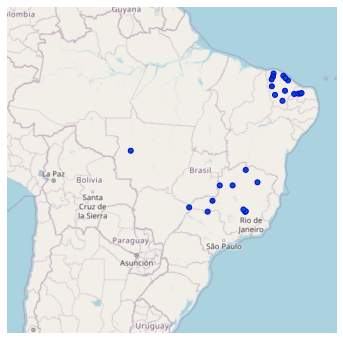

In [86]:
points = pd.read_sql("select code, responsible, water_body, year, count, mean, min, max, stddev, variance, ST_AsText(geometry) as geometry, state_initial from point", con)

points['geometry'] = points['geometry'].apply(wkt.loads)
points_gpd = gpd.GeoDataFrame(points, geometry="geometry")
points_gt_85 = points_gpd[points_gpd['mean'] > 85]

br_ax = gplt.webmap(cities_gpd, projection = gcrs.WebMercator())
gplt.pointplot(points_gt_85, ax=br_ax, hue=points_gpd['mean'], edgecolor="blue", norm=norm, cmap=cmap, extent=extent)


Em sequência, estão sendo apresentados os corpos com índice de qualidade da água abaixo de 25. Percebe que a maioria desses pontos se encontram no estado do Rio de Janeiro.

<GeoAxesSubplot:>

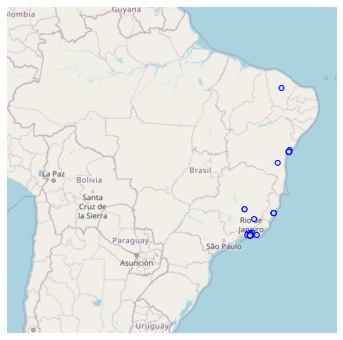

In [89]:
points_lt_25 = points_gpd[points_gpd['mean'] < 25]

br_ax = gplt.webmap(cities_gpd, projection = gcrs.WebMercator())
gplt.pointplot(points_lt_25, ax=br_ax, hue=points_gpd['mean'], edgecolor="blue", norm=norm, cmap=cmap, extent=extent)

<h3>2.8 Analisando os estados da dupla</h3>
<p>O integrante Cleomar mora no Mato Grosso, cuja distribuição dos corpos hídricos está sendo mostrada logo abaixo:</p>

<GeoAxesSubplot:>

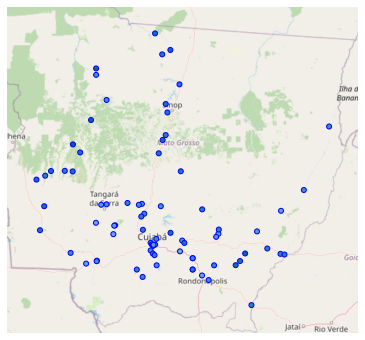

In [121]:
mt_map = cities_gpd[cities_gpd['state'] == 'MT']
mt_points = points_gpd[points_gpd['state_initial'] == 'MT']

mt_ax = gplt.webmap(mt_map, projection = gcrs.WebMercator())
gplt.pointplot(mt_points, ax=mt_ax, hue=points_gpd['mean'], norm=norm, cmap=cmap, edgecolor="blue")

Além disso, o corpo hídrico com melhor índice de qualidade do estado é o Rio Papagaio, com índice 86,4.

In [109]:
print(mt_points[mt_points['mean'] == mt_points['mean'].max()][['water_body', 'mean']])

        water_body  mean
1047  Rio Papagaio  86.4


Por outro lado, o integrante Gabriel Pastori mora no Paraná, cuja distribuição dos corpos hídricos está sendo apresentada a seguir: 

<GeoAxesSubplot:>

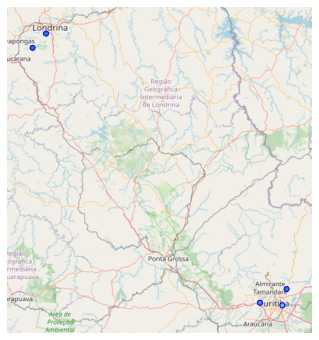

In [122]:
pr_map = cities_gpd[cities_gpd['state'] == 'PR']
pr_points = points_gpd[points_gpd['state_initial'] == 'PR']

pr_ax = gplt.webmap(pr_map, projection = gcrs.WebMercator())
gplt.pointplot(pr_points, ax=pr_ax, hue=points_gpd['mean'], norm=norm, cmap=cmap, edgecolor="blue")

Sendo que o corpo hídrico com maior índice do estado é o Rio Apertados, com índice 72,3.

In [107]:
print(df_points[df_points['mean'] == df_points['mean'].max()][['water_body', 'mean']])

        water_body  mean
333  Rio Apertados  72.3


<h2>3 Conclusão</h2>
<p>Considerando os dados apresentados neste trabalho, é possível afirmar que o Brasil é um país extremamente desigual no que diz respeito à qualidade da água. Além disso, o fato do Rio de Janeiro possuir o pior índice médio de qualidade da água do Brasil é algo inesperado e preocupante, visto que é uma das maiores e mais importantes cidades do país.</p>